# Redes de Convolução

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf

In [3]:
# reinicia grafo do tensorflow
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [4]:
# save and restore net in memory
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

# Convoluções

In [5]:
import skimage.measure # scikit-image

Para entendermos convolução e pooling, vamos inicialmente ver o que essas operações fazem em pequenos exemplos de imagens.

Para isso, vamos criar uma função para exibir matrizes como imagens em tons de cinza.

In [6]:
def plot_figs(lst):
    if len(lst) == 1:
        plt.matshow(lst[0], cmap = 'gray', interpolation='nearest')
    else:
        f, axes = plt.subplots(1, len(lst))
        for i, a in enumerate(axes):
            a.matshow(lst[i], cmap = 'gray', interpolation='nearest')
            a.set(aspect='equal')

E então exibir exemplos de imagens simples (ex0 e ex1) e de um kernel simples (k0):

In [7]:
ex0 = np.array([[0,0,0,1,0,0,0,0],
                [0,0,1,0,0,0,0,0],
                [0,1,0,0,0,0,0,0],
                [1,0,0,0,0,0,0,0],
                [0,0,0,0,1,0,0,0],
                [0,0,0,0,0,1,0,0],
                [0,0,0,0,0,0,1,0],
                [0,0,0,0,0,0,0,1]], dtype=np.float32)

In [8]:
ex1 = np.array([[0,0,0,0,0,0,0,1],
                [0,0,0,0,0,0,0,1],
                [0,0,0,0,0,0,1,0],
                [0,0,0,0,0,0,1,0],
                [0,0,0,0,0,1,0,0],
                [0,0,0,0,0,1,0,0],
                [0,0,0,0,1,0,0,0],
                [0,0,0,0,1,0,0,0]], dtype=np.float32)

In [9]:
k0 = np.array([[0,0,0,1],
               [0,0,1,1],
               [0,0,1,0],
               [0,1,0,0]], dtype=np.float32)

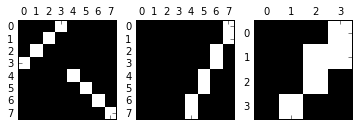

In [10]:
plot_figs([ex0, ex1, k0])

O componente básico da operação de convolução é o produto (interno) entre a entrada ($\bf{x}$) e o kernel ($\bf{w}$), com saída opcionalmente transformada, por exemplo, para ter uma interpretação probabilística. Ou seja, ela pode ser representada como $\sigma({\bf x}^{T} {\bf w})$, onde $\sigma$ pode ser a função sigmoid:

In [11]:
def conv0(a1, a2):
    sigmoid = lambda n: 1. / (1. + np.exp(-n))
    a1r = a1.reshape((-1, 1))
    a2r = a2.reshape((-1, 1))
    return sigmoid(np.sum(np.multiply(a1r, a2r)))
    # return sigmoid(np.dot(a1r.T, a2r))[0,0]

0.88079707933191798

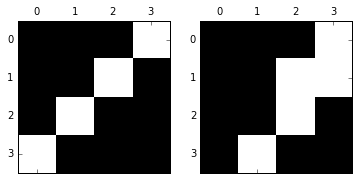

In [12]:
plot_figs([ex0[:4,:4], k0])
conv0(ex0[:4,:4], k0)

Ao aplicar conv0 para k0 e a parte superior esquerda de ex0, notamos que o padrão k0 é parcialmente observado em ex0 (probabilidade de 88%).

0.73105857373994898

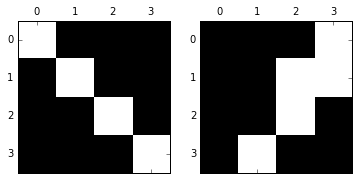

In [13]:
plot_figs([ex0[4:,4:], k0])
conv0(ex0[4:,4:], k0)

Ao aplicar conv0 para k0 e a parte inferior direira de ex0, notamos que o padrão k0 é observado com certeza menor (probabilidade de 73%), umas vez que houve coincidência em um único ponto.

0.95257412817534082

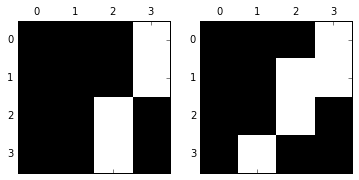

In [14]:
ex1p = skimage.measure.block_reduce(ex1, (2,2), np.max)
plot_figs([ex1p, k0])
conv0(ex1p, k0)

Ao aplicar conv0 para k0 e uma versão _reduzida_ de ex1, notamos que o padrão k0 é observado com certo grau de certeza (probabilidade de 95%).

Destes exemplos, podemos interpretar a operação de convolução como um problema de dizer se um padrão pode ou não ser visto em uma imagem. Podemos ver também que reduzir a imagem (uma operação de _pooling_) pode tornar um padrão visível.

A seguir, vamos ver a aplicação da operação de convolução completa de um kernel sobre uma imagem.

Para isso vamos usar o operador de convolução conv2D do tensorflow. Os parâmetros deste operador são a imagem de entrada (tensor 4D [número de batches, altura, largura, número de canais]), o conjunto de kernels a serem aplicados (tensor 4D [altura, largura, canais de entrada, canais de saída]), os delocamentos a serem aplicados (no conjunto de batches, nos pixels da altura, pixels da largura e canais de entrada) e o tipo de _padding_ a ser realizado ('VALID' = sem padding ou 'SAME' = tentar manter o mesmo padding em cada margem). 

In [15]:
def tfconv(imgs, kernels):
    reset_graph()

    # batch, alt, larg, canais entrada
    X = tf.constant(imgs, dtype=tf.float32) 
    feature_maps = tf.constant(kernels)
    convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], 
                               padding="SAME")
    
    with tf.Session() as s:
        output = convolution.eval(feed_dict={X: imgs})
    return output

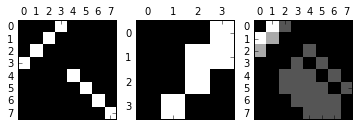

In [16]:
# alt, larg, canais de entrada, canais de saida
fmap = k0.reshape(k0.shape[0], k0.shape[1], 1, 1)
output = tfconv(ex0.reshape(1, ex0.shape[0], ex0.shape[1], 1), fmap)
plot_figs([ex0, k0, output[0, :, :, 0]])

Ao aplicar convolução do kernel k0 em ex0, notamos que o padrão k0 é observado na parte superior esquerda da imagem, mas não muito claramente na parte inferior esquerda. Esta é a forma como pode ser interpretada a imagem resultante da convolução.

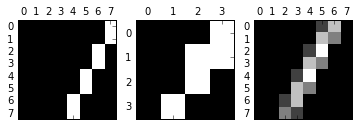

In [17]:
output = tfconv(ex1.reshape(1, ex1.shape[0], ex1.shape[1], 1), fmap)
plot_figs([ex1, k0, output[0, :, :, 0]])

Ao aplicar convolução do kernel k0 em ex1, notamos que o padrão k0 parece ser observado ao longo de ex1, ao lado esquerdo (em particular, mais na parte superior que na parte inferior da imagem).

Finalmente, vamos ver o efeito de padrões (kernels) mais complexos em uma imagem real.

In [18]:
im = Image.open('images/building.jpeg') 
image = np.asarray(im) 

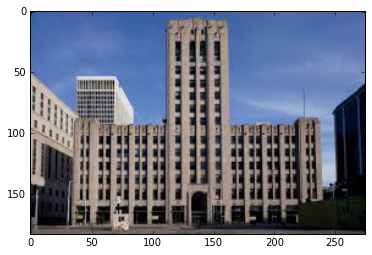

In [19]:
plt.imshow(image)

In [20]:
image.shape

(183, 275, 3)

In [21]:
height, width, channels = image.shape
image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width, 1)

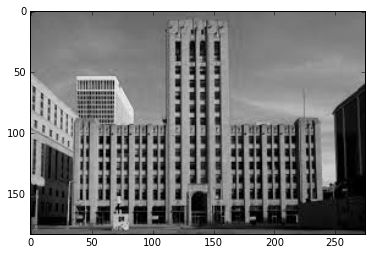

In [22]:
plt.imshow(images[0,:,:,0], cmap = 'gray')

Para tanto, vamos usar dois padrões: uma linha verticar e outra horizontal.

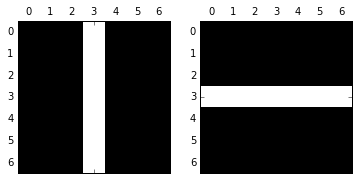

In [23]:
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1
plot_figs([fmap[:, :, 0, 0], fmap[:, :, 0, 1]])

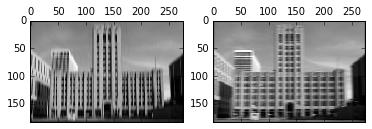

In [24]:
output = tfconv(images, fmap)
plot_figs([output[0, :, :, 0], output[0, :, :, 1]])

Percebam que, na imagem resultante, são ressaltadas as linhas verticais e horizontais da imagem original, enfatizando _onde_ esses padrões são vistos.

A seguir, vamos parametrizar nossa função de convolução para observar o efeito de diferentes strides e padding.

In [25]:
def tfconv(img, kernels, stride_val = 1, pad_val = 'SAME'):
    reset_graph()

    # batch, alt, larg, canais entrada
    X = tf.constant(img, dtype=tf.float32) 
    feature_maps = tf.constant(kernels)
    convolution = tf.nn.conv2d(X, feature_maps, 
                               strides=[1, stride_val, stride_val, 1], 
                               padding=pad_val)
    
    with tf.Session() as s:
        output = convolution.eval(feed_dict={X: img})
    return output

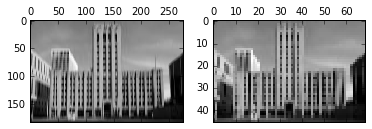

In [26]:
# stride 4 --> imagem é reduzida 4 vezes
output4 = tfconv(images, fmap, 4)
plot_figs([output[0, :, :, 0], output4[0, :, :, 0]])

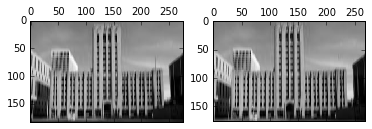

In [27]:
# sem padding, quase não se nota mudança em uma imagem tão grande, exceto nas bordas.
outputv = tfconv(images, fmap, pad_val = 'VALID')
plot_figs([output[0, :, :, 0], outputv[0, :, :, 0]])

Vamos agora introduzir pooling no processo. Note que o efeito do pooling é similar a striding na convolução, ou seja, redução da imagem.

In [28]:
def tfconv(img, kernels, stride_val = 1, pad_val = 'SAME', pool_val = 2):
    reset_graph()

    # batch, alt, larg, canais entrada
    X = tf.constant(img, dtype=tf.float32) 
    feature_maps = tf.constant(kernels)
    convolution = tf.nn.conv2d(X, feature_maps, 
                               strides=[1, stride_val, stride_val, 1], 
                               padding=pad_val)
    # max pool!!!
    max_pool = tf.nn.max_pool(convolution, 
                              ksize=[1, pool_val, pool_val, 1], 
                              strides=[1,pool_val,pool_val,1], 
                              padding="VALID")
    
    with tf.Session() as s:
        output = max_pool.eval(feed_dict={X: img})
    return output

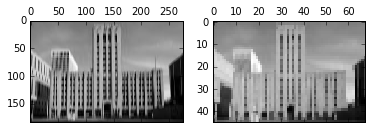

In [29]:
outputmax = tfconv(images, fmap, pool_val = 4)
plot_figs([output[0, :, :, 0], outputmax[0, :, :, 0]])

## Uma rede de convolução (CNN - Convolutional Neural Network)

Uma rede de convolução é basicamente uma rede neural com camadas em que se aplicam convoluções e pooling. Os pesos dos neurônios em camadas de convolução correspondem a kernels. Logo, os neurônios filtram as imagens que chegam em busca de padrões partculares. Os pesos nas camadas de pooling são sempre 1 e nunca se alteram. Ou seja, elas não fazem nada além de algum tipo de amostragem, reduzindo a quantidade de informação que vai seguir pela rede.

Abaixo, vamos usar uma CNN para classificar MNIST.

In [30]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/MNIST_data")

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


Nossa CNN tem $28 \times 28$ sinais de entrada. Estes sinais são entregues para um rede de convolução com 8 kernels. As 8 imagens resultantes de $28 \times 28$ pixels sao entrada de uma segunda rede de convolução, com 16 kernels e stride 2. Ou seja, ela reduz a entrada produzindo 16 imagens de $14 \times 14$ pixels. Esses passam por uma camada de pooling que os reduz para 16 imagens de $7 \times 7$ pixels. Esses $16 \times 7 \times 7$ sinais são então dados como entrada para 64 neurônios (camada que chamamos FC1) que, por sua vez, se conectam com outros 10 neurônios. Cada neurônio deste, então, representa um digito diferente. Logo eles podem ser combinados via _softmax_ para determinar o dígito mais provável da rede.

In [31]:
height = 28
width = 28
channels = 1
n_inputs = height * width

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
    X_reshaped = tf.reshape(X, shape=(-1, height, width, channels))
    y = tf.placeholder(tf.int32, shape=(None), name="y")

# input: 28x28 image (batch images)
conv1 = tf.layers.conv2d(X_reshaped, filters=8, kernel_size=3,
                         strides=1, padding='SAME',
                         activation=tf.nn.relu, name="conv1")
# input: 8 28x28
conv2 = tf.layers.conv2d(conv1, filters=16, kernel_size=3,
                         strides=2, padding='SAME',
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    # input: 16 14x14 
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], 
                           strides=[1, 2, 2, 1], padding="VALID")
    # output: 16 7x7 
    pool3_flat = tf.reshape(pool3, shape=(-1, 16 * 7 * 7))

with tf.name_scope("fc1"):
    # input: 16x7x7
    fc1 = tf.layers.dense(pool3_flat, 64, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, 10, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [32]:
n_epochs = 10
batch_size = 100

with tf.Session() as s:
    init.run()
    for e in range(n_epochs):
        for i in range(mnist.train.num_examples // batch_size):
            X_b, y_b = mnist.train.next_batch(batch_size)
            s.run(training_op, feed_dict={X: X_b, y: y_b})
        acc_tr = accuracy.eval(feed_dict={X: X_b, y: y_b})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, 
                                            y: mnist.test.labels})
        print '%d: acc tr = %.5f test = %.5f' % (e, acc_tr, acc_test)

        saver.save(s, "/tmp/my_mnist_model")

0: acc tr = 0.96000 test = 0.95710
1: acc tr = 0.98000 test = 0.97180
2: acc tr = 0.97000 test = 0.97990
3: acc tr = 0.99000 test = 0.98240
4: acc tr = 0.99000 test = 0.98320
5: acc tr = 0.97000 test = 0.98540
6: acc tr = 1.00000 test = 0.98630
7: acc tr = 1.00000 test = 0.98600
8: acc tr = 1.00000 test = 0.98720
9: acc tr = 1.00000 test = 0.98460


In [33]:
height = 28
width = 28
channels = 1
n_inputs = height * width

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
    X_reshaped = tf.reshape(X, shape=(-1, height, width, channels))
    y = tf.placeholder(tf.int32, shape=(None), name="y")
    # dropout
    training = tf.placeholder_with_default(False, shape=(), name='training')

# input: 28x28 image (batch images)
conv1 = tf.layers.conv2d(X_reshaped, filters=8, kernel_size=3,
                         strides=1, padding='SAME',
                         activation=tf.nn.relu, name="conv1")
# input: 8 28x28
conv2 = tf.layers.conv2d(conv1, filters=16, kernel_size=3,
                         strides=2, padding='SAME',
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    # input: 16 14x14 
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], 
                           strides=[1, 2, 2, 1], padding="VALID")
    # output: 16 7x7 
    pool3_flat = tf.reshape(pool3, shape=(-1, 16 * 7 * 7))
    # drop
    pool3_flat_drop = tf.layers.dropout(pool3_flat, rate = 0.25, 
                                       training = training)

with tf.name_scope("fc1"):
    # input: 16x7x7
    fc1 = tf.layers.dense(pool3_flat, 64, activation=tf.nn.relu, name="fc1")
    # drop
    fc1_drop = tf.layers.dropout(fc1, rate = 0.5, training = training)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, 10, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [34]:
n_epochs = 10
batch_size = 100

with tf.Session() as s:
    init.run()
    for e in range(n_epochs):
        for i in range(mnist.train.num_examples // batch_size):
            X_b, y_b = mnist.train.next_batch(batch_size)
            s.run(training_op, feed_dict={X: X_b, 
                                          y: y_b,
                                          training: True}) # dropout
        acc_tr = accuracy.eval(feed_dict={X: X_b, y: y_b})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, 
                                            y: mnist.test.labels})
        print '%d: acc tr = %.5f test = %.5f' % (e, acc_tr, acc_test)

        saver.save(s, "/tmp/my_mnist_model")

0: acc tr = 0.96000 test = 0.96720
1: acc tr = 0.98000 test = 0.97710
2: acc tr = 0.96000 test = 0.98040
3: acc tr = 0.99000 test = 0.98260
4: acc tr = 0.99000 test = 0.98290
5: acc tr = 0.98000 test = 0.98280
6: acc tr = 0.98000 test = 0.98670
7: acc tr = 0.99000 test = 0.98620
8: acc tr = 1.00000 test = 0.98560
9: acc tr = 1.00000 test = 0.98520


In [36]:
n_epochs = 1000
batch_size = 64

best_loss = np.infty
best_model = None
check_interval = 500
epochs_with_no_progress = 0
max_epochs_with_no_progress = 35

with tf.Session() as s:
    init.run()
    for e in range(n_epochs):
        for i in range(mnist.train.num_examples // batch_size):
            X_b, y_b = mnist.train.next_batch(batch_size)
            s.run(training_op, feed_dict={X: X_b, 
                                          y: y_b,
                                          training: True}) # dropout
            if i % check_interval == 0:
                loss_val = loss.eval(feed_dict={
                    X: mnist.validation.images,
                    y: mnist.validation.labels})
                if loss_val < best_loss:
                    best_loss = loss_val
                    epochs_with_no_progress = 0
                    best_model = get_model_params()
                else:
                    epochs_with_no_progress += 1
        acc_tr = accuracy.eval(feed_dict={X: X_b, y: y_b})
        acc_val = accuracy.eval(feed_dict={X: mnist.validation.images, 
                                            y: mnist.validation.labels})
        print '%d: acc tr = %.5f val = %.5f' % (e, acc_tr, acc_val)
        if epochs_with_no_progress > max_epochs_with_no_progress:
            print 'Stopping earlier...'
            break

    if best_model:
        restore_model_params(best_model)
    acc_test = accuracy.eval(feed_dict={X: mnist.test.images, 
                                        y: mnist.test.labels})
    print 'acc test = %.5f' % (acc_test)
    saver.save(s, "/tmp/my_mnist_model")

0: acc tr = 0.96875 val = 0.97000
1: acc tr = 0.96875 val = 0.98060
2: acc tr = 0.98438 val = 0.98140
3: acc tr = 0.96875 val = 0.98480
4: acc tr = 1.00000 val = 0.98620
5: acc tr = 1.00000 val = 0.98860
6: acc tr = 1.00000 val = 0.98880
7: acc tr = 1.00000 val = 0.98860
8: acc tr = 1.00000 val = 0.98800
9: acc tr = 1.00000 val = 0.98580
10: acc tr = 1.00000 val = 0.98800
11: acc tr = 1.00000 val = 0.99100
12: acc tr = 1.00000 val = 0.99060
13: acc tr = 1.00000 val = 0.98820
14: acc tr = 1.00000 val = 0.98820
15: acc tr = 1.00000 val = 0.98820
16: acc tr = 1.00000 val = 0.98920
17: acc tr = 1.00000 val = 0.98980
18: acc tr = 1.00000 val = 0.98940
19: acc tr = 1.00000 val = 0.98900
20: acc tr = 1.00000 val = 0.98860
21: acc tr = 1.00000 val = 0.99040
22: acc tr = 1.00000 val = 0.98960
23: acc tr = 1.00000 val = 0.98900
24: acc tr = 1.00000 val = 0.99080
25: acc tr = 1.00000 val = 0.98520
Stopping earlier...
acc test = 0.98600


In [39]:
sorted(best_model.keys())

[u'conv1/bias',
 u'conv1/bias/Adam',
 u'conv1/bias/Adam_1',
 u'conv1/kernel',
 u'conv1/kernel/Adam',
 u'conv1/kernel/Adam_1',
 u'conv2/bias',
 u'conv2/bias/Adam',
 u'conv2/bias/Adam_1',
 u'conv2/kernel',
 u'conv2/kernel/Adam',
 u'conv2/kernel/Adam_1',
 u'fc1/bias',
 u'fc1/bias/Adam',
 u'fc1/bias/Adam_1',
 u'fc1/kernel',
 u'fc1/kernel/Adam',
 u'fc1/kernel/Adam_1',
 u'output/bias',
 u'output/bias/Adam',
 u'output/bias/Adam_1',
 u'output/kernel',
 u'output/kernel/Adam',
 u'output/kernel/Adam_1',
 u'train/beta1_power',
 u'train/beta2_power']

In [40]:
best_model['conv1/kernel']

array([[[[ 0.41202769,  0.28069299,  0.23104291,  0.00347972, -0.38989162,
          -0.3201904 , -0.06635064,  0.25827155]],

        [[ 0.49311486,  0.10189533, -0.01135853,  0.37183067, -0.20373259,
           0.08251899,  0.03644699, -0.13841096]],

        [[ 0.15526189,  0.51654327, -0.02631436, -0.1805938 ,  0.26938379,
          -0.0917319 ,  0.43693453, -0.2964977 ]]],


       [[[-0.12170871,  0.06477178,  0.29939088,  0.33406687,  0.32399422,
          -0.1308448 , -0.0665875 ,  0.39865661]],

        [[ 0.21533038, -0.02996039,  0.47817883,  0.12218391,  0.33624372,
           0.44944009,  0.25488031,  0.02679604]],

        [[-0.19446367,  0.00808572,  0.30085853, -0.4353404 , -0.11601126,
           0.54448748,  0.33421972, -0.40107289]]],


       [[[ 0.06267068, -0.27854854, -0.17034633,  0.19530405,  0.46407276,
           0.31173623,  0.23270614,  0.33039552]],

        [[-0.09197349, -0.32227206,  0.24619642, -0.05393106,  0.26227951,
           0.03928828,  0.231524

In [41]:
best_model['conv1/kernel'].shape

(3, 3, 1, 8)

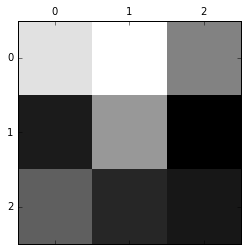

In [44]:
plot_figs([best_model['conv1/kernel'][:,:,0,0]])

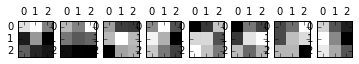

In [45]:
plot_figs([best_model['conv1/kernel'][:,:,0,i] 
           for i in range(8)])

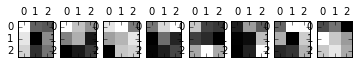

In [46]:
plot_figs([best_model['conv2/kernel'][:,:,0,i] 
           for i in range(8)])

In [47]:
with tf.Session() as s:
    saver.restore(s, '/tmp/my_mnist_model')
    conv2kernel_vals = conv2.eval(feed_dict={X: mnist.test.images[0:1], 
                                             y: mnist.test.labels[0:1]})

INFO:tensorflow:Restoring parameters from /tmp/my_mnist_model


In [48]:
conv2kernel_vals.shape

(1, 14, 14, 16)

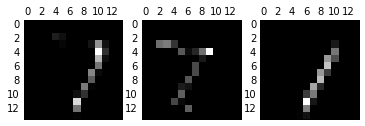

In [49]:
plot_figs([conv2kernel_vals[0,:,:,i] for i in range(3)])

In [50]:
with tf.Session() as s:
    saver.restore(s, '/tmp/my_mnist_model')
    fc1_vals = fc1.eval(feed_dict={X: mnist.test.images[0:100], 
                                   y: mnist.test.labels[0:100]})

INFO:tensorflow:Restoring parameters from /tmp/my_mnist_model


In [51]:
fc1_vals.shape

(100, 64)

In [53]:
from sklearn.neighbors import NearestNeighbors
import random

In [54]:
neigh = NearestNeighbors(2)
neigh.fit(fc1_vals)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=2, p=2, radius=1.0)

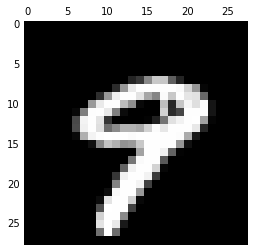

In [57]:
ridx = random.randint(0, 99)
plot_figs([mnist.test.images[ridx].reshape((28,28))])

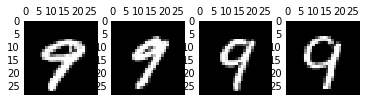

In [59]:
indices = neigh.kneighbors([fc1_vals[ridx]], 4, return_distance=False)
plot_figs([mnist.test.images[i].reshape((28,28)) for i in indices[0]])